C:\Users\sasha\PycharmProjects\F24-PMLDL-Project\venv\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\sasha\PycharmProjects\F24-PMLDL-Project\venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


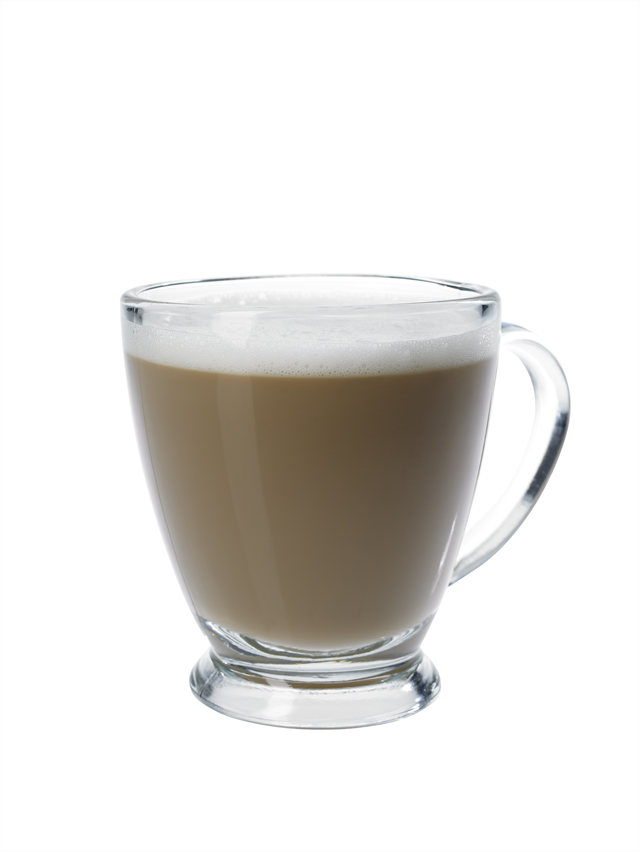

In [1]:
from PIL import Image, ImageOps
from transparent_background import Remover
import numpy as np
from diffusers import ControlNetModel
import os
import torch

# img = Image.open("../data/monin/combined_dataset/test/1725657501_6166165.png").convert('RGB')
img = Image.open("../frontend/src/assets/PARFAIT_mask.jpg").convert("RGB")
img

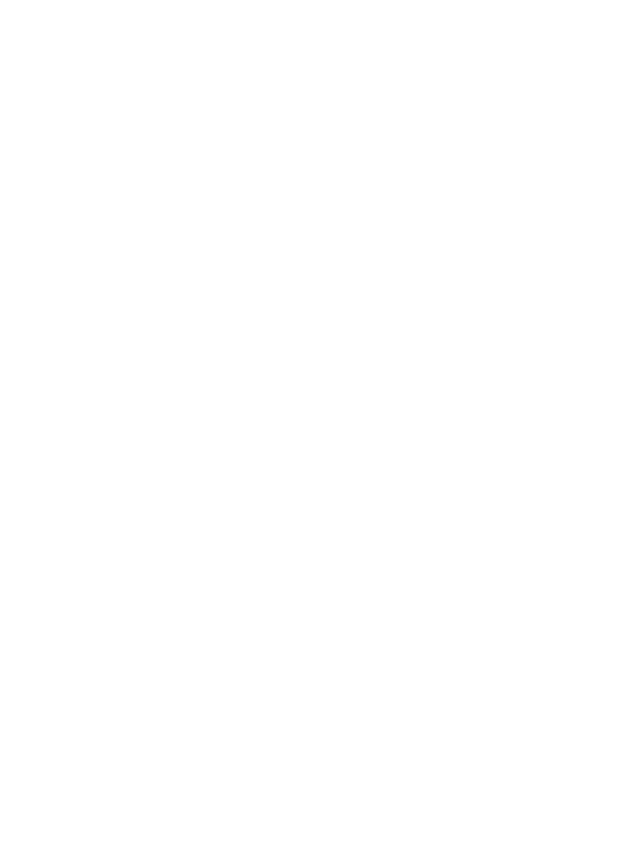

In [2]:
white_img = Image.new('RGB', img.size, color='white')
white_img

In [3]:
def plot_images(images):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(20,10))
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

C:\Users\sasha\PycharmProjects\F24-PMLDL-Project\venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\sasha\PycharmProjects\F24-PMLDL-Project\venv\Lib\site-packages\transparent_background\Remover.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed durin

Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


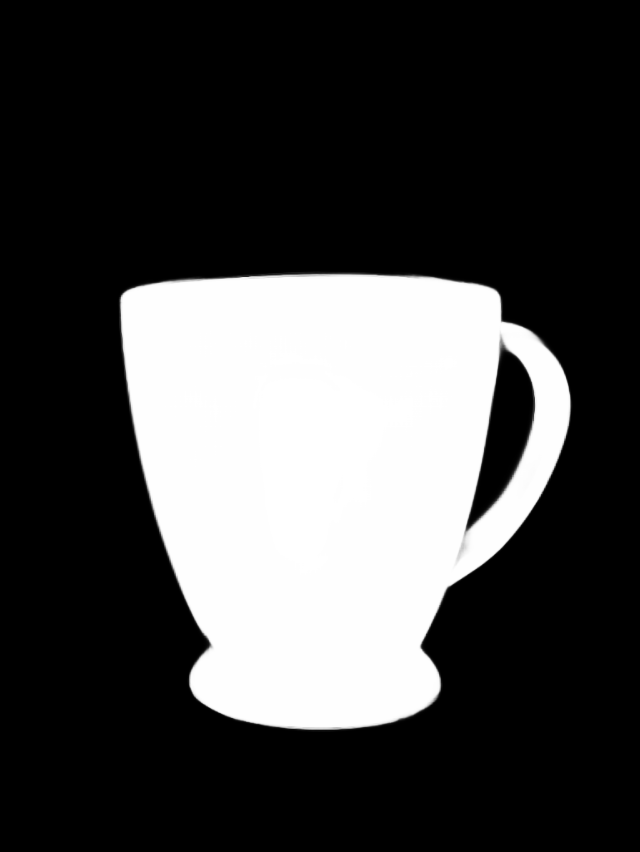

In [4]:
from transparent_background import Remover

remover = Remover() 
remover = Remover(mode='base') 

mask_real = remover.process(img, type='map')
mask_real

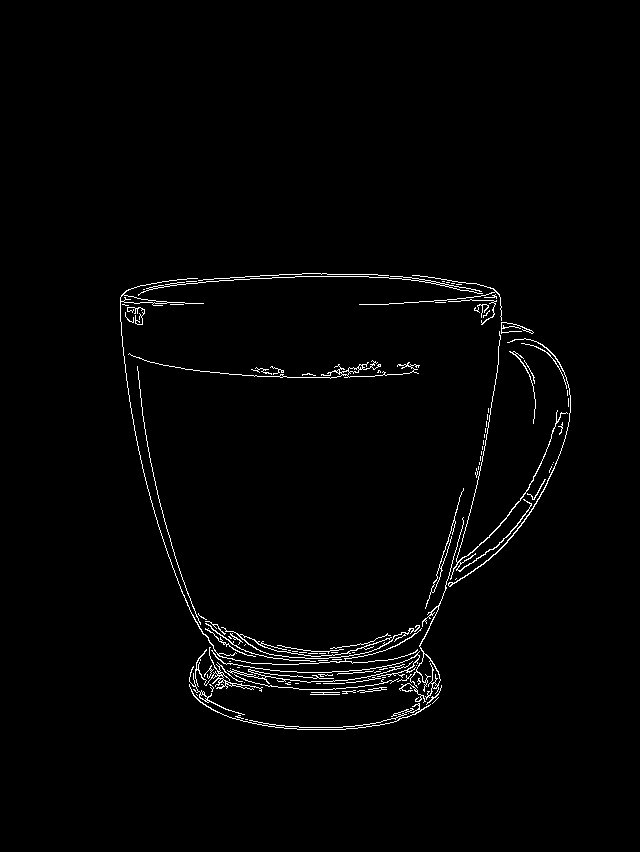

In [5]:
import cv2
import numpy as np
from PIL import Image

image = np.array(img)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

otsu_thresh, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

high_threshold = otsu_thresh
low_threshold = 0.2 * otsu_thresh 

canny_image = cv2.Canny(gray_image, int(low_threshold), int(high_threshold))


canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)
canny_image


In [6]:
torch.cuda.empty_cache()

from diffusers import StableDiffusionControlNetInpaintPipeline


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("ThreeBibas/sd1.5-napitochki-finetune", torch_dtype=torch.float16, controlnet=controlnet)


pipe = pipe.to("cuda")
# prompt = "Name: 'Luck Of The Irish' Frozen Lemonade; Recipie: 3/4 oz. Monin Pistachio Syrup\n3/4 oz. Monin Ginger Syrup\n2 oz. fresh lemon sour mix\n\nFill serving glass full of ice.\nPour ingredients into blender cup in order listed.\nAdd ice from serving glass, cap, and blend until smooth.\nPour back into serving glass, add garnish and serve.; Category: lemonade"

# prompt = "Name: Bourbon Spice Iced Coffee; Recipie: ice\n1 1/4 oz. bourbon\n1 oz. Monin Iced Coffee Concentrate\n1/2 oz. Monin Cinnamon Bun Syrup\n4 oz. cold milk\n\nFill serving glass full of ice.\nPour ingredients into mixing tin in order listed.\nAdd ice from serving glass.\nCap, shake and pour back into serving glass.\nAdd garnish and serve.; Category: coffee"

prompt = "Name: Blarney Kissed Coffee; Recipie: 1 1/4 oz. Irish whiskey\n1/4 oz. Monin Spiced Brown Sugar Syrup\n1/2 oz. Monin Irish Cream Syrup\n1 oz. half & half\nFill with fresh brewed coffee\n\nFill serving glass full of hot water to warm glass.\nDiscard hot water and pour ingredients into serving glass in order listed.\nStir gently to mix.\nAdd garnish and serve.; Category: coffee"

negative_prompt = 'low quality, bad quality, sketches'

images = pipe(prompt=prompt, negative_prompt=negative_prompt, image=white_img, control_image=canny_image, mask_image=mask_real, num_images_per_prompt=6).images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stir gently to mix . add garnish and serve .; category : coffee']


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

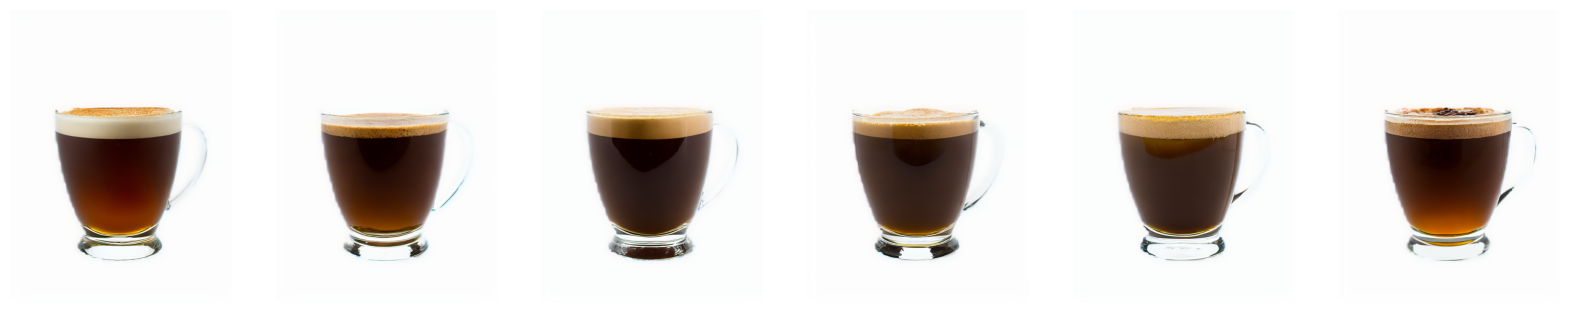

In [7]:
plot_images(images)